# Funzioni

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

def fit_predict_print(train, test, target_columns, estimator):
  X_tr = train.drop(columns=target_columns)
  y_tr = train[target_columns]
  X_ts = test.drop(columns=target_columns)
  y_ts = test[target_columns]

  return fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, estimator)


def fit_predict_print_1(X_train, X_test, y_train, y_test, estimator):
  y_pred = estimator.fit(X_train, y_train).predict(X_test)

  print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
  cm = metrics.confusion_matrix(y_test, y_pred)
  print('Confusion matrix:\n', cm)
  cmn = metrics.confusion_matrix(y_test, y_pred, normalize='true')
  ConfusionMatrixDisplay(cmn, display_labels=estimator.classes_).plot()
  return y_pred

In [ ]:
def balanced_subsample(X, y, subsample_size=1.0):

    classes = y.unique()
    min_elems = y.value_counts().min()

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems * subsample_size)

    Xb = pd.DataFrame()
    yb = pd.Series()

    for c in classes:
      X_ = X[y == c]
      if X_.shape[0] > use_elems:
        X_ = X_.sample(use_elems)

      yc = np.empty(use_elems)
      yc.fill(c)
      y_ = pd.Series(yc)

      Xb = pd.concat([Xb, X_])
      yb = pd.concat([yb, y_])

    return Xb, yb

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(dataset, columns, drop=None):

  categories = []
  ret_columns = []

  if isinstance(columns, str):
    columns = [columns]
  if (drop is not None) and (isinstance(drop, str)):
    drop = [drop]

  for i in range(0, len(columns)):
    ctg = dataset.loc[:, columns[i]].unique().tolist()
    categories.append(ctg)

    ctg_ = ctg.copy();
    if drop is not None:
      ctg_.remove(drop[i])
    ret_columns += ctg_

  encoder = OneHotEncoder(categories=categories, drop=drop).fit(dataset[columns])
  ds = pd.DataFrame(encoder.transform(dataset[columns]).toarray(), columns=ret_columns)

  return ds


def add_dummies(dataset, columns, drop_cat=None, drop_col=True):
  dummies = one_hot_encode(dataset, columns, drop_cat)
  if drop_col:
    ret = pd.concat([dataset.drop(columns=columns), dummies], axis=1)
  else:
    ret = pd.concat([dataset, dummies], axis=1)
  return ret

In [ ]:
def xtab(rows_data, cols_data, normalize_rows=False):
  xtab = pd.crosstab(rows_data, cols_data)
  if normalize_rows:
    for i in xtab.index:
      xtab.loc[i] = xtab.loc[i] / (rows_data == i).sum()
    _ = sns.heatmap(xtab, vmin=0, vmax=1)
  else:
    _ = sns.heatmap(xtab)
  print(xtab)
  return xtab

In [ ]:
def voting_classifier(estimators, X_train_list, y_train_list, X_test):

    preds = np.asarray([clf.fit(X, y).predict(X_test) for clf, X, y in
                        zip(estimators, X_train_list, y_train_list)])
    modes = np.apply_along_axis(lambda x: np.bincount(x).argmax(),
                                axis=0, arr=preds)

    return modes

# Parte 1: Analisi

1

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BDA/data/new_weather.csv')

In [ ]:
dataset.head()

,Date,Max_Temperature_F,Mean_Temperature_F,Min_TemperatureF,Max_Dew_Point_F,MeanDew_Point_F,Min_Dewpoint_F,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Sea_Level_Pressure_In,Mean_Sea_Level_Pressure_In,Min_Sea_Level_Pressure_In,Max_Visibility_Miles,Mean_Visibility_Miles,Min_Visibility_Miles,Max_Wind_Speed_MPH,Mean_Wind_Speed_MPH,Events,Month,Year,Day
0,2014-10-13,71,62.0,54,55,51,46,87,68,46,30.03,29.79,29.65,10,10,4,13,4,Rain,10.0,2014.0,13.0
1,2014-10-14,63,59.0,55,52,51,50,88,78,63,29.84,29.75,29.54,10,9,3,10,5,Rain,10.0,2014.0,14.0
2,2014-10-15,62,58.0,54,53,50,46,87,77,67,29.98,29.71,29.51,10,9,3,18,7,Rain,10.0,2014.0,15.0
3,2014-10-16,71,61.0,52,49,46,42,83,61,36,30.03,29.95,29.81,10,10,10,9,4,Rain,10.0,2014.0,16.0
4,2014-10-17,64,60.0,57,55,51,41,87,72,46,29.83,29.78,29.73,10,10,6,8,3,Rain,10.0,2014.0,17.0


2

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        689 non-null    object 
 1   Max_Temperature_F           689 non-null    int64  
 2   Mean_Temperature_F          688 non-null    float64
 3   Min_TemperatureF            689 non-null    int64  
 4   Max_Dew_Point_F             689 non-null    int64  
 5   MeanDew_Point_F             689 non-null    int64  
 6   Min_Dewpoint_F              689 non-null    int64  
 7   Max_Humidity                689 non-null    int64  
 8   Mean_Humidity               689 non-null    int64  
 9   Min_Humidity                689 non-null    int64  
 10  Max_Sea_Level_Pressure_In   689 non-null    float64
 11  Mean_Sea_Level_Pressure_In  689 non-null    float64
 12  Min_Sea_Level_Pressure_In   689 non-null    float64
 13  Max_Visibility_Miles        689 non

In [ ]:
dataset.Events.value_counts()

Rain                   287
Fog                     16
Fog , Rain               7
Fog-Rain                 6
Rain-Thunderstorm        4
Rain , Thunderstorm      3
Snow                     2
Rain-Snow                2
Rain , Snow              1
Name: Events, dtype: int64

3

In [ ]:
dataset['Range_Temperature'] = dataset.Max_Temperature_F - dataset.Min_TemperatureF

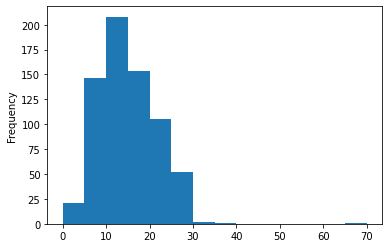

In [ ]:
dataset.Range_Temperature.plot(kind='hist', bins=range(0, 71, 5))
# outlier

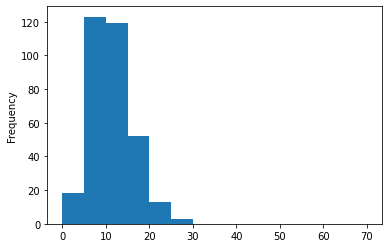

In [ ]:
ds = dataset.copy()

ds['Range_Temperature'] = dataset.Max_Temperature_F - dataset.Min_TemperatureF

ds.dropna(inplace=True)
ds.reset_index(drop=True, inplace=True)

ds.Range_Temperature.plot(kind='hist', bins=range(0, 71, 5))
#outlier corrisponde all'istanza in cui manca la temperatura minima

4

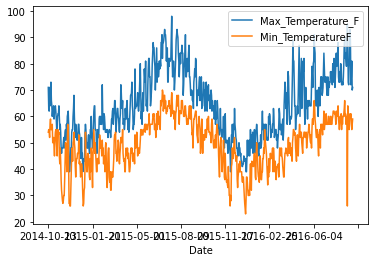

In [ ]:
dataset.plot(x='Date', y=['Max_Temperature_F', 'Min_TemperatureF'])

5

In [ ]:
dataset[dataset.Year == 2015].Events.count() # skips nan

171

Events  Fog  Fog , Rain  Fog-Rain  ...  Rain-Snow  Rain-Thunderstorm  Snow
Month                              ...                                    
1.0       9           2         0  ...          2                  0     0
2.0       1           2         2  ...          0                  0     0
3.0       0           2         1  ...          0                  1     0
4.0       0           0         0  ...          0                  0     0
5.0       0           0         0  ...          0                  0     0
6.0       0           0         0  ...          0                  1     0
7.0       0           0         0  ...          0                  0     0
8.0       0           0         0  ...          0                  0     0
9.0       0           0         0  ...          0                  0     0
10.0      3           1         0  ...          0                  0     0
11.0      1           0         2  ...          0                  0     1
12.0      2           0  

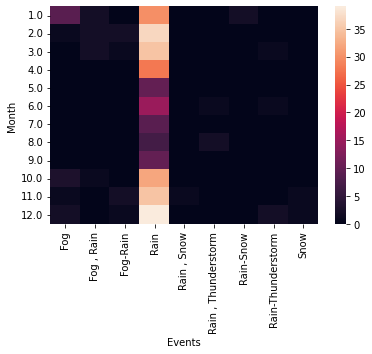

In [ ]:
ds2015 = dataset[dataset.Year == 2015][['Month', 'Events']]
_ = xtab(ds.Month, ds.Events)

6

In [ ]:
pt = pd.pivot_table(dataset, values='Mean_Temperature_F', index=['Year', 'Month'], columns='Events')

In [ ]:
pt

Events              Fog  Fog , Rain  ...  Rain-Thunderstorm  Snow
Year   Month                         ...                         
2014.0 10.0         NaN         NaN  ...                NaN   NaN
       11.0         NaN         NaN  ...                NaN   NaN
       12.0   48.000000         NaN  ...                NaN   NaN
2015.0 1.0    45.833333        46.0  ...                NaN   NaN
       2.0          NaN        47.5  ...                NaN   NaN
       3.0          NaN        49.0  ...                NaN   NaN
       4.0          NaN         NaN  ...                NaN   NaN
       5.0          NaN         NaN  ...                NaN   NaN
       6.0          NaN         NaN  ...                NaN   NaN
       7.0          NaN         NaN  ...                NaN   NaN
       8.0          NaN         NaN  ...                NaN   NaN
       9.0          NaN         NaN  ...                NaN   NaN
       10.0   55.666667        62.0  ...                NaN   NaN
       11.0   34.000000         NaN  ...                NaN  36.0
       12.0         NaN         NaN  ...               51.0  42.0
2016.0 1.0    38.666667         NaN  ...                NaN   NaN
       2.0    50.000000         NaN  ...                NaN   NaN
       3.0          NaN         NaN  ...               44.0   NaN
       4.0          NaN         NaN  ...                NaN   NaN
       5.0          NaN         NaN  ...                NaN   NaN
       6.0          NaN         NaN  ...               66.0   NaN
       7.0          NaN         NaN  ...                NaN   NaN
       8.0          NaN         NaN  ...                NaN   NaN

[23 rows x 9 columns]

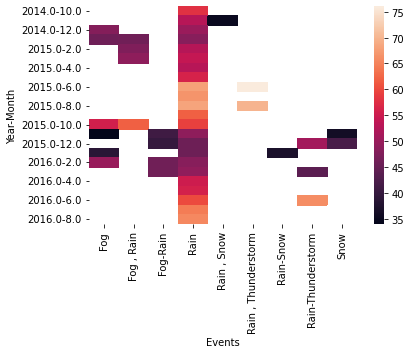

In [ ]:
_ = sns.heatmap(pt)

# Parte 2: Trasformazione e Predizione

1

In [ ]:
dataset1 = dataset.copy()
dataset1.Events = np.where(dataset.Events.isna(), 0, 1)

dataset1.drop(columns='Date', inplace=True) # Testuale e ridondate, ci sono già Year, Month e Day
dataset1.dropna(inplace=True)
dataset1.reset_index(drop=True, inplace=True)

In [ ]:
dataset1.Events.value_counts()

0    360
1    328
Name: Events, dtype: int64

2, 3, 4

In [ ]:
train, test = train_test_split(dataset1, train_size=2/3, random_state=1)

In [ ]:
from sklearn.naive_bayes import BernoulliNB

Accuracy: 0.5391304347826087
Confusion matrix:
 [[114   1]
 [105  10]]


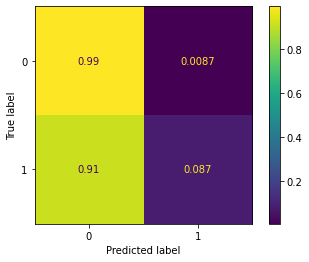

In [ ]:
_ = fit_predict_print(train, test, 'Events', BernoulliNB())

5

In [ ]:
from sklearn.tree import DecisionTreeClassifier

Accuracy: 0.782608695652174
Confusion matrix:
 [[87 28]
 [22 93]]


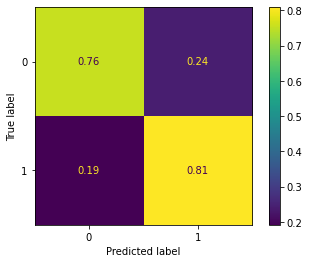

In [ ]:
_ = fit_predict_print(train, test, 'Events', DecisionTreeClassifier())

6

In [ ]:
X = dataset1.drop(columns='Events')
y = dataset1.Events

In [ ]:
cross_val_score(BernoulliNB(), X, y, cv=5, scoring='accuracy',
                n_jobs=-1).mean()

0.5595578123347085

In [ ]:
cross_val_score(DecisionTreeClassifier(), X, y, cv=5, scoring='accuracy',
                n_jobs=-1).mean()

0.7558764413413732

7

LR: 0.854625 (0.033828)
KNN: 0.806586 (0.049902)
DT: 0.777558 (0.037618)
BNB: 0.559633 (0.014618)
GNB: 0.792178 (0.025788)
SVM: 0.523274 (0.003069)


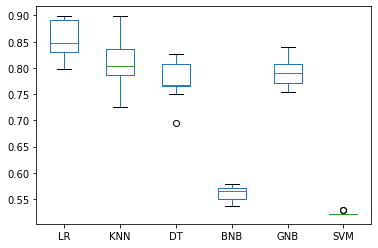

In [ ]:
boxplot_models_performance(X, y)

8

In [ ]:
reduced = dataset1.drop(columns=[
  'Max_Temperature_F', 'Min_TemperatureF',
  'Max_Dew_Point_F', 'Min_Dewpoint_F',
  'Max_Humidity', 'Min_Humidity',
  'Max_Sea_Level_Pressure_In', 'Min_Sea_Level_Pressure_In',
  'Max_Visibility_Miles', 'Min_Visibility_Miles',
  'Max_Wind_Speed_MPH'])

In [ ]:
reduced.columns

Index(['Mean_Temperature_F', 'MeanDew_Point_F', 'Mean_Humidity',
       'Mean_Sea_Level_Pressure_In', 'Mean_Visibility_Miles',
       'Mean_Wind_Speed_MPH', 'Events', 'Month', 'Year', 'Day',
       'Range_Temperature'],
      dtype='object')

In [ ]:
to_cut = ['Mean_Temperature_F', 'MeanDew_Point_F', 'Mean_Humidity',
       'Mean_Sea_Level_Pressure_In', 'Mean_Visibility_Miles',
       'Mean_Wind_Speed_MPH', 'Range_Temperature']

for c in to_cut:
  reduced[c] = pd.cut(reduced[c], bins=6, labels=range(1, 7, 1))

In [ ]:
reduced.head()

,Mean_Temperature_F,MeanDew_Point_F,Mean_Humidity,Mean_Sea_Level_Pressure_In,Mean_Visibility_Miles,Mean_Wind_Speed_MPH,Events,Month,Year,Day,Range_Temperature
0,4,6,4,2,6,2,1,10.0,2014.0,13.0,2
1,4,6,5,2,6,2,1,10.0,2014.0,14.0,1
2,3,6,5,2,6,3,1,10.0,2014.0,15.0,1
3,4,5,4,3,6,2,1,10.0,2014.0,16.0,2
4,4,6,5,2,6,2,1,10.0,2014.0,17.0,1


In [ ]:
train, test = train_test_split(reduced, train_size=2/3, random_state=1)

Accuracy: 0.8217391304347826
Confusion matrix:
 [[94 21]
 [20 95]]


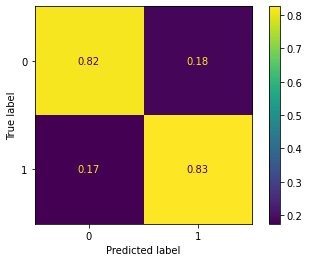

In [ ]:
_ = fit_predict_print(train, test, 'Events', LogisticRegression(n_jobs=-1))

9

In [ ]:
train, test = train_test_split(reduced, train_size=.75, random_state=1)

In [ ]:
dataset1 = train[train.Month.between(1, 4)]
dataset2 = train[train.Month.between(5, 8)]
dataset3 = train[train.Month.between(9, 12)]

dataset1.drop(columns='Month', inplace=True)
dataset2.drop(columns='Month', inplace=True)
dataset3.drop(columns='Month', inplace=True)
test.drop(columns='Month', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
X_tr_1 = dataset1.drop(columns='Events')
y_tr_1 = dataset1.Events
X_tr_2 = dataset2.drop(columns='Events')
y_tr_2 = dataset2.Events
X_tr_3 = dataset3.drop(columns='Events')
y_tr_3 = dataset3.Events

X_ts = test.drop(columns='Events')
y_ts = test.Events

In [ ]:
from sklearn.tree import DecisionTreeClassifier as DTC

In [ ]:
y_pr = voting_classifier([DTC(), DTC(), DTC()], [X_tr_1, X_tr_2, X_tr_3],
                  [y_tr_1, y_tr_2, y_tr_3], X_ts)

Accuracy: 0.7034883720930233
Confusion matrix:
 [[65 26]
 [25 56]]


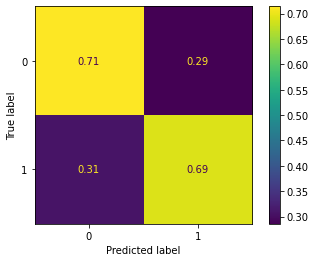

In [ ]:
print('Accuracy:', metrics.accuracy_score(y_ts, y_pr))
cm = metrics.confusion_matrix(y_ts, y_pr)
print('Confusion matrix:\n', cm)
cmn = metrics.confusion_matrix(y_ts, y_pr, normalize='true')
_ = ConfusionMatrixDisplay(cmn).plot()

10

In [ ]:
# Rimuovo Day e Year, per eccessiva ramificazione. Assumo che gli eventi
# atmosferici dipendano solo dal mese (realistico, a meno di eventi straordinari)
reduced.drop(columns=['Day', 'Year'], inplace=True)

KeyError: ignored

In [ ]:
train, test = train_test_split(reduced, train_size=2/3, random_state=1)

Accuracy: 0.8260869565217391
Confusion matrix:
 [[94 21]
 [19 96]]


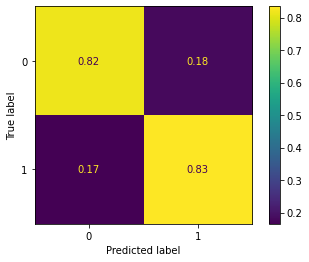

In [ ]:
_ = fit_predict_print(train, test, 'Events', LogisticRegression(n_jobs=-1))